In [1]:
from ROOT import TMVA, TFile, TTree, TCut, TString
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Concatenate, Dense, LSTM, Input, Reshape, Dropout, RNN, BatchNormalization
from tensorflow.keras.optimizers import Adagrad, SGD, RMSprop, Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import eli5
from eli5.sklearn import PermutationImportance
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import pandas as pd
import random
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from IPython import display
import graphviz
from numba import cuda
from array import array
import pickle
import scikitplot as skplt
import seaborn as sns
import pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule
from math import sqrt
import swats

Welcome to JupyROOT 6.19/01


In [2]:
signalFile=TFile.Open("../sample-0702/sig_bbTotal.root")
ttbarFile=TFile.Open("../sample-0702/bkg_ttbar.root")
DYFile=TFile.Open("../sample-0702/bkg_DY.root")
backgroundFile=TFile.Open("../sample-train/bkg_total.root")

In [3]:
signalTree=signalFile.Get("ntup")
ttbarTree=ttbarFile.Get("ntup")
DYTree=DYFile.Get("ntup")
backgroundTree=backgroundFile.Get("ntup")

In [4]:
signalNum=signalTree.GetEntries()
backgroundNum=backgroundTree.GetEntries()
print("signal events number before cut is: ",signalNum)
print("background events number before cut is: ",backgroundNum)

signal events number before cut is:  379199
background events number before cut is:  18069795


In [5]:
signalArray=signalTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
#signalArray=signalTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
    
#backgroundArray=backgroundTree.AsMatrix(["weight","is_em","is_me","bjet_0_eta","bjet_1_pt","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                #"bb_pt","bb_deltar","bb_deltaeta","met_sig","met_phi","mt_lep0_met","mt_lep1_met"])
ttbarArray=ttbarTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

DYArray=DYTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])
backgroundArray=backgroundTree.AsMatrix(["weight","is_ee","is_mm","bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                              "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"])

In [6]:
print("signal yield before cut is: ",sum(signalArray[:,0]))
print("background yield before cut is:",sum(ttbarArray[:,0]))
print("background yield before cut is:",sum(DYArray[:,0]))
print("background yield before cut is:",sum(backgroundArray[:,0]))

signal yield before cut is:  15.600508562739876
background yield before cut is: 1527391.75482141
background yield before cut is: 534476.1252861483
background yield before cut is: 2169748.186742322


In [7]:
signalSample2=signalArray[(abs(signalArray[:,7])>75000.0)&((signalArray[:,1]==1)|(signalArray[:,2]==1))]
ttbarSample2=ttbarArray[(abs(ttbarArray[:,7])>75000.0)&((ttbarArray[:,1]==1)|(ttbarArray[:,2]==1))]
DYSample2=DYArray[(abs(DYArray[:,7])>75000.0)&((DYArray[:,1]==1)|(DYArray[:,2]==1))]
backgroundSample2=backgroundArray[(abs(backgroundArray[:,7])>75000.0)&((backgroundArray[:,1]==1)|(backgroundArray[:,2]==1))]


In [8]:
signalNum=len(signalSample2)
backgroundNum=len(backgroundSample2)
print("signal event number after cut is: ",signalNum)
print("background event number after cut is:",backgroundNum)
print("signal yield after cut is: ",sum(signalSample2[:,0]))
print("background yield after cut is:",sum(backgroundSample2[:,0]))
SBratio=sum(signalSample2[:,0])/sum(backgroundSample2[:,0])
print("S/B ratio is: ",SBratio)
SigYield=sum(signalSample2[:,0])
BkgYield=sum(backgroundSample2[:,0])

signal event number after cut is:  52680
background event number after cut is: 11425015
signal yield after cut is:  0.4901765247906553
background yield after cut is: 960273.1071347836
S/B ratio is:  5.104553289565926e-07


In [9]:
signalSample=signalSample2[(signalSample2[:,12]>80000)&(signalSample2[:,12]<150000)&(signalSample2[:,14]<2.8)]
ttbarSample=ttbarSample2[(ttbarSample2[:,12]>80000)&(ttbarSample2[:,12]<150000)&(ttbarSample2[:,14]<2.8)]
DYSample=DYSample2[(DYSample2[:,12]>80000)&(DYSample2[:,12]<150000)&(DYSample2[:,14]<2.8)]
backgroundSample=backgroundSample2[(backgroundSample2[:,12]>80000)&(backgroundSample2[:,12]<150000)&(backgroundSample2[:,14]<2.8)]

In [10]:
GBDT_ttbar = pickle.load(open("../BDT_model/0723/GBDT_HH_region1_ttbar.pickle.dat", "rb"))
GBDT_DY = pickle.load(open("../BDT_model/0723/GBDT_HH_region1_DY.pickle.dat", "rb"))

In [11]:
varName=["bjet_0_pt","bjet_0_eta","bjet_1_pt","bjet_1_eta","ll_m","ll_pt","ll_deltar","ll_deltaeta","ll_deltaphi","bb_m",
                                "bb_pt","bb_deltar","bb_deltaeta","bb_deltapt","met_met","met_sig","met_phi","mt_lep0_met","mt_lep1_met","m_bbll","m_bbllmet"]
BDTSignal=xgb.DMatrix(signalSample[:,3:],feature_names=varName)
BDTttbar=xgb.DMatrix(ttbarSample[:,3:],feature_names=varName)
BDTDY=xgb.DMatrix(DYSample[:,3:],feature_names=varName)
BDTBkg=xgb.DMatrix(backgroundSample[:,3:],feature_names=varName)

In [12]:
signal_ttbar_score=GBDT_ttbar.predict(BDTSignal)
signal_DY_score=GBDT_DY.predict(BDTSignal)

ttbar_ttbar_score=GBDT_ttbar.predict(BDTttbar)
ttbar_DY_score=GBDT_DY.predict(BDTttbar)

DY_ttbar_score=GBDT_ttbar.predict(BDTDY)
DY_DY_score=GBDT_DY.predict(BDTDY)

bkg_ttbar_score=GBDT_ttbar.predict(BDTBkg)
bkg_DY_score=GBDT_DY.predict(BDTBkg)


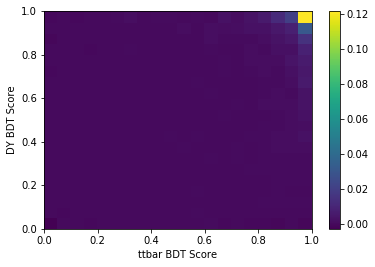

In [13]:
plt.hist2d(signal_ttbar_score,signal_DY_score,weights=signalSample[:,0],bins=(20, 20))
plt.ylabel('DY BDT Score')
plt.xlabel('ttbar BDT Score')
plt.colorbar()
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/region1-2d-sig.pdf', format='pdf', dpi=500)
#plt.hist2d(ttbar_ttbar_score,ttbar_DY_score,weights=ttbarSample[:,0],bins=(20, 20))

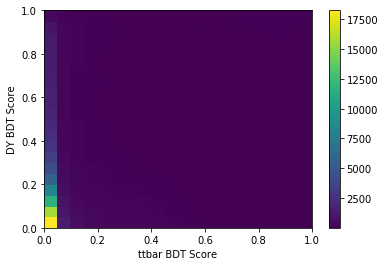

In [14]:
plt.hist2d(ttbar_ttbar_score,ttbar_DY_score,weights=ttbarSample[:,0],bins=(20, 20))
plt.ylabel('DY BDT Score')
plt.xlabel('ttbar BDT Score')
plt.colorbar()
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/region1-2d-ttbar.pdf', format='pdf', dpi=500)

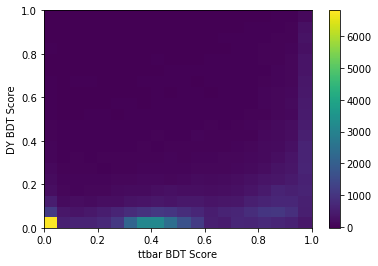

In [15]:
plt.hist2d(DY_ttbar_score,DY_DY_score,weights=DYSample[:,0],bins=(20, 20))
plt.ylabel('DY BDT Score')
plt.xlabel('ttbar BDT Score')
plt.colorbar()
figure_fig = plt.gcf()  # 'get current figure'
figure_fig.savefig('../figures/0725/region1-2d-DY.pdf', format='pdf', dpi=500)

In [25]:
drv.init()
mod=SourceModule("""
__global__ void func1(double *a, double *d, double *b, double *c, double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  extern __shared__ double sharedMem1[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     double t;
     t=(a[i]-thre)*(a[i]-thre)+(d[i]-thre)*(d[i]-thre)-(1-thre)*(1-thre);
     if((a[i]>thre)&&(d[i]>thre)&&(t>0)){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func1=mod.get_function("func1") 

In [26]:
def cuda_sum(nump1,nump3,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    num3=np.float64(nump3.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func1(drv.InOut(num1),drv.InOut(num3),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [27]:
i=0.1
eff=(0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,1,0.001):
    if(j>=4):
        break
    resS=cuda_sum(signal_ttbar_score,signal_DY_score,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(bkg_ttbar_score,bkg_DY_score,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(signal_ttbar_score,signal_DY_score,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)

(0.6, 0.5, 0.4, 0.3)
If cut BDT at  0.321 signal yield is: [0.29414494]  Eff is: [0.60007962]  background yield is: [7605.12166639]  Eff is:  [0.00791975]  S/B ratio is:  [3.86772174e-05]  Significance is:  [0.00337294]
If cut BDT at  0.602 signal yield is: [0.24493581]  Eff is: [0.49968899]  background yield is: [3185.85740718]  Eff is:  [0.00331766]  S/B ratio is:  [7.68822274e-05]  Significance is:  [0.00433949]
If cut BDT at  0.762 signal yield is: [0.19599069]  Eff is: [0.39983696]  background yield is: [1388.82131022]  Eff is:  [0.00144628]  S/B ratio is:  [0.00014112]  Significance is:  [0.00525911]
If cut BDT at  0.853 signal yield is: [0.14713308]  Eff is: [0.30016346]  background yield is: [584.9738917]  Eff is:  [0.00060917]  S/B ratio is:  [0.00025152]  Significance is:  [0.00608334]


In [ ]:
drv.init()
mod=SourceModule("""
__global__ void func2(double *a, double *b, double *c, double thre, int N)
{ 
  extern __shared__ double sharedMem[256];
  double x=0;
  int index=threadIdx.x+blockIdx.x*blockDim.x;
  int stride=blockDim.x*gridDim.x;
  sharedMem[threadIdx.x]=0;
  //if(index<N){
    //sharedMem[threadIdx.x]=b[index];
  //}
  for(int i=index;i<N;i=i+stride){
     if(a[i]>thre){
     sharedMem[threadIdx.x]+=b[i];
     }
  }
   
   __syncthreads();
   
   for(int offset=blockDim.x/2;offset>0;offset>>=1){
      if(threadIdx.x<offset){
      sharedMem[threadIdx.x]+=sharedMem[threadIdx.x+offset];
      }
      __syncthreads();
   }
   if(threadIdx.x==0){
      c[blockIdx.x]=sharedMem[0];
   }
   
}
""")
func2=mod.get_function("func2") 

In [ ]:
def cuda_sum(nump1,nump2,th):
    num1=np.float64(nump1.copy(order='C'))
    num2=np.float64(nump2.copy(order='C'))
    thres=np.float64(th)
    nThreads=256
    nBlocks=68
    c1=np.zeros((68,1))
    N=np.int32(len(nump1))
    func2(drv.InOut(num1),drv.InOut(num2),drv.InOut(c1),thres,N,block=(nThreads, 1, 1),grid=(nBlocks,1))
    return(sum(c1))

In [ ]:
i=0.1
eff=(0.8,0.7,0.6,0.5,0.4,0.3)
j=0
k=0
t=0
min_diff=100
print(eff)
for i in np.arange(0,4,0.001):
    if(j>=6):
        break
    resS=cuda_sum(signal_DY_score,signalSample[:,0],i)
    ratio=resS/SigYield
    if(abs(ratio-eff[j])<0.05):
        t=1
        if(k==0):
            min_diff=100
        if(abs(ratio-eff[j])<min_diff):
            min_diff=abs(ratio-eff[j])
            BDT_cut=i
        k=k+1
           
    if(abs(ratio-eff[j])>0.05):
        if(t==1):
            j=j+1
            k=0
            t=0
            resB=cuda_sum(bkg_DY_score,backgroundSample[:,0],BDT_cut)
            resS=cuda_sum(signal_DY_score,signalSample[:,0],BDT_cut)
            SBratio=resS/resB
            Sig=resS/sqrt(resB)
            print("If cut BDT at ",BDT_cut, "signal yield is:",resS," Eff is:", resS/SigYield," background yield is:",resB,
              " Eff is: ", resB/BkgYield," S/B ratio is: ",SBratio," Significance is: ",Sig)